In [1]:
%load_ext watermark


In [2]:
import re

from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
from teeplot import teeplot as tp


In [3]:
%watermark -diwmuv -iv


Last updated: 2026-02-13T12:09:37.110440+00:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.31.1

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.8.0-1044-azure
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit

teeplot   : 1.4.2
seaborn   : 0.13.2
matplotlib: 3.10.0
re        : 2.2.1
pandas    : 2.2.3

Watermark: 2.4.3



In [4]:
teeplot_subdir = "2026-02-11-billion-tip-benchmark-v1_20_24"


## Helpers


In [5]:
def strip_slice_notation(step_name: str) -> str:
    return re.sub(r"\(\s*\d+\s*/\s*\d+\s*\)", "", step_name).strip()


def combine_slices(df: pd.DataFrame) -> pd.DataFrame:
    df["what_base"] = df["what"].apply(strip_slice_notation)
    group_cols = [
        "what_base",
        "phylo_source_path",
        "revision",
        "dstream_S",
        "dstream_value_bitwidth",
        "num_tips",
        "cpu_count",
        "date",
        "hostname",
    ]
    summed_df = df.groupby(group_cols, as_index=False).agg(
        {"duration (s)": "sum"}
    )
    summed_df.rename(columns={"what_base": "what"}, inplace=True)
    return summed_df


## Prep Data


In [6]:
df = pd.read_csv("https://osf.io/download/guwq5/")
df


,what,duration (s),phylo_source_path,revision,dstream_S,dstream_value_bitwidth,num_tips,cpu_count,date,hostname
0,pa.ipc.open_file(source).read_all(),0.000347,/mnt/ufs18/rs-011/ecode_lab/mmore500/2025-02-1...,f9c054a01fd961b22731cde6fb22de84e23871d9,64,1,1000000000,128,2026-02-11T20:59:23.875296,acm-017
1,pa_array['dstream_data_id'].to_numpy(),0.000109,/mnt/ufs18/rs-011/ecode_lab/mmore500/2025-02-1...,f9c054a01fd961b22731cde6fb22de84e23871d9,64,1,1000000000,128,2026-02-11T20:59:23.875296,acm-017
2,pa_array['dstream_T'].to_numpy(),0.000017,/mnt/ufs18/rs-011/ecode_lab/mmore500/2025-02-1...,f9c054a01fd961b22731cde6fb22de84e23871d9,64,1,1000000000,128,2026-02-11T20:59:23.875296,acm-017
3,pa_array['dstream_Tbar'].to_numpy(),0.000012,/mnt/ufs18/rs-011/ecode_lab/mmore500/2025-02-1...,f9c054a01fd961b22731cde6fb22de84e23871d9,64,1,1000000000,128,2026-02-11T20:59:23.875296,acm-017
4,pa_array['dstream_value'].to_numpy(),0.000010,/mnt/ufs18/rs-011/ecode_lab/mmore500/2025-02-1...,f9c054a01fd961b22731cde6fb22de84e23871d9,64,1,1000000000,128,2026-02-11T20:59:23.875296,acm-017
...,...,...,...,...,...,...,...,...,...,...
69,alifestd_delete_trunk_asexual,24.565517,/mnt/ufs18/rs-011/ecode_lab/mmore500/2025-02-1...,f9c054a01fd961b22731cde6fb22de84e23871d9,64,1,1000000000,128,2026-02-11T20:38:59.080855,acm-069
70,alifestd_prefix_roots,189.865286,/mnt/ufs18/rs-011/ecode_lab/mmore500/2025-02-1...,f9c054a01fd961b22731cde6fb22de84e23871d9,64,1,1000000000,128,2026-02-11T20:38:59.080855,acm-069
71,alifestd_collapse_unifurcations,49.278389,/mnt/ufs18/rs-011/ecode_lab/mmore500/2025-02-1...,f9c054a01fd961b22731cde6fb22de84e23871d9,64,1,1000000000,128,2026-02-11T20:38:59.080855,acm-069
72,trie_postprocessor,20.633667,/mnt/ufs18/rs-011/ecode_lab/mmore500/2025-02-1...,f9c054a01fd961b22731cde6fb22de84e23871d9,64,1,1000000000,128,2026-02-11T20:38:59.080855,acm-069


In [7]:
df_adaptive = df[df["phylo_source_path"].str.contains("purifyingplus")].copy()
df_non_adaptive = df[
    df["phylo_source_path"].str.contains("purifyingonly")
].copy()


In [8]:
summed_non_adaptive = combine_slices(df_non_adaptive)
summed_adaptive = combine_slices(df_adaptive)

summed_non_adaptive["method"] = "Purifying\nRegime"
summed_adaptive["method"] = "Adaptive\nRegime"


In [9]:
df_combined = pd.concat(
    [summed_non_adaptive, summed_adaptive], ignore_index=True
)
df_combined["duration (h)"] = df_combined["duration (s)"] / 3600

df_hstrat = df_combined[
    df_combined["what"] == "hstrat.dataframe.surface_build_tree"
].copy()
total_hstrat = (
    df_hstrat.groupby("method")["duration (h)"]
    .sum()
    .reset_index(name="hstrat_total_h")
)

df_parts = df_combined[
    df_combined["what"] != "hstrat.dataframe.surface_build_tree"
].copy()


def recategorize(what: str) -> str:
    if what in [
        "extend_tree_searchtable_cpp_from_exploded",
        "collapse_unifurcations(dropped_only=True)",
    ]:
        return what
    else:
        return "postprocessing"


df_parts["category"] = df_parts["what"].apply(recategorize)

grouped_parts = df_parts.groupby(["method", "category"], as_index=False).agg(
    {"duration (h)": "sum"}
)
total_parts = (
    df_parts.groupby("method")["duration (h)"]
    .sum()
    .reset_index(name="parts_total_h")
)

total_summary = pd.merge(total_hstrat, total_parts, on="method", how="left")
total_summary["other"] = (
    total_summary["hstrat_total_h"] - total_summary["parts_total_h"]
)

df_other = total_summary[["method", "other"]].copy()
df_other = df_other.rename(columns={"other": "duration (h)"})
df_other["category"] = "other"

final_df = pd.concat([grouped_parts, df_other], ignore_index=True)
final_df


,method,category,duration (h)
0,Adaptive\nRegime,collapse_unifurcations(dropped_only=True),0.278450
1,Adaptive\nRegime,extend_tree_searchtable_cpp_from_exploded,1.849773
2,Adaptive\nRegime,postprocessing,0.240018
3,Purifying\nRegime,collapse_unifurcations(dropped_only=True),0.337103
4,Purifying\nRegime,extend_tree_searchtable_cpp_from_exploded,2.150843
5,Purifying\nRegime,postprocessing,0.266443
6,Adaptive\nRegime,other,0.514503
7,Purifying\nRegime,other,0.468221


## Filled Graph


teeplots/2026-02-11-billion-tip-benchmark-v1_20_24/hue=category+multiple=fill+palette=ylgnbu+viz=histplot+weights=duration-h+y=method+ext=.pdf
teeplots/2026-02-11-billion-tip-benchmark-v1_20_24/hue=category+multiple=fill+palette=ylgnbu+viz=histplot+weights=duration-h+y=method+ext=.png


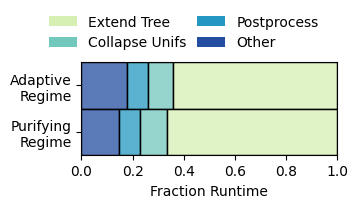

In [10]:
with tp.teed(
    sns.histplot,
    data=final_df,
    y="method",
    hue="category",
    weights="duration (h)",
    multiple="fill",
    discrete=True,
    hue_order=[
        "extend_tree_searchtable_cpp_from_exploded",
        "collapse_unifurcations(dropped_only=True)",
        "postprocessing",
        "other",
    ],
    palette="YlGnBu",
    teeplot_subdir=teeplot_subdir,
) as ax:
    legend_labels = ["Extend Tree", "Collapse Unifs", "Postprocess", "Other"]

    ax.figure.set_size_inches(3.3, 1.2)

    ax.set_xlabel("Fraction Runtime")
    ax.set_ylabel("")

    palette = sns.color_palette("YlGnBu", 4)
    custom_handles = [
        Patch(facecolor=palette[i], label=legend_labels[i])
        for i in range(len(legend_labels))
    ]

    ax.legend(
        handles=custom_handles,
        bbox_to_anchor=(1.05, 0.5),
        loc="center left",
        fontsize=8,
    )

    sns.move_legend(
        ax,
        "lower center",
        bbox_to_anchor=(0.4, 1),
        ncol=2,
        title=None,
        frameon=False,
        columnspacing=0.8,
    )


## Stacked Graph


teeplots/2026-02-11-billion-tip-benchmark-v1_20_24/hue=category+multiple=stack+palette=ylgnbu+viz=histplot+weights=duration-h+y=method+ext=.pdf
teeplots/2026-02-11-billion-tip-benchmark-v1_20_24/hue=category+multiple=stack+palette=ylgnbu+viz=histplot+weights=duration-h+y=method+ext=.png


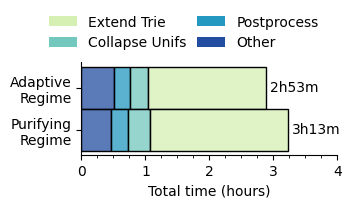

In [11]:
with tp.teed(
    sns.histplot,
    data=final_df,
    y="method",
    hue="category",
    weights="duration (h)",
    multiple="stack",
    discrete=True,
    hue_order=[
        "extend_tree_searchtable_cpp_from_exploded",
        "collapse_unifurcations(dropped_only=True)",
        "postprocessing",
        "other",
    ],
    palette="YlGnBu",
    teeplot_subdir=teeplot_subdir,
) as ax:
    ax.figure.set_size_inches(3.3, 1.2)
    legend_labels = ["Extend Trie", "Collapse Unifs", "Postprocess", "Other"]

    ax.set_xlabel("Total time (hours)")
    ax.set_ylabel("")

    ax.set_xlim(0, 4)
    ax.set_xticks([0, 1, 2, 3, 4])

    ax.xaxis.minorticks_on()
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.25))

    palette = sns.color_palette("YlGnBu", 4)
    custom_handles = [
        Patch(facecolor=palette[i], label=legend_labels[i])
        for i in range(len(legend_labels))
    ]

    ax.legend(
        handles=custom_handles,
        bbox_to_anchor=(1.05, 0.5),
        loc="center left",
        fontsize=8,
    )

    sns.move_legend(
        ax,
        "lower center",
        bbox_to_anchor=(0.4, 1),
        ncol=2,
        title=None,
        frameon=False,
        columnspacing=0.8,
    )

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    totals = final_df.groupby("method")["duration (h)"].sum()
    methods = [tick.get_text() for tick in ax.get_yticklabels()]
    labels = []
    for m in methods:
        h = totals[m]
        hrs = int(h)
        mins = int(round((h - hrs) * 60))
        labels.append(f"{hrs}h{mins}m")
    ax.bar_label(
        ax.containers[-1],
        labels=labels,
        label_type="edge",
        padding=3,
        fontsize=10,
    )
